In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from viz_utils import *
from dataloaders import *

import os
import pickle
import itertools
import pandas as pd
from collections import defaultdict

In [21]:
from podium.datasets.impl import SST


fields = {
            "text": Field(
                "text",
                numericalizer=Vocab(),
                include_lengths=True,
                keep_raw=True,
            ),
            "label": LabelField("label"),
        }
train, val, test = SST.get_dataset_splits(fields = fields)

In [33]:
from podium import Vocab, Field, LabelField
from podium.datasets import SST

vocab = Vocab(max_size=5000, specials=())
text = Field(name='text', numericalizer=vocab, disable_batch_matrix=True)
label = LabelField(name='label')
fields = {'text': text, 'label': label}
train, dev, test = SST.get_dataset_splits(fields=fields)
train.finalize_fields()
x, y = train.batch(add_padding=True)

In [37]:
from podium.vectorizers import TfIdfVectorizer
tfidf_vectorizer = TfIdfVectorizer()
tfidf_vectorizer.fit(train, field=train.field('text'))
tfidf_x = tfidf_vectorizer.transform(x)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [26]:
train_df = train.to_pandas(include_raw=True)[["text_raw", "label"]]
train_df = train_df[train_df["text_raw"].str.split().str.len() >= 3].reset_index()
del train_df["index"]

In [30]:
train_df.label.value_counts()

positive    3599
negative    3296
Name: label, dtype: int64

In [71]:
train = pd.read_csv("data/SST/JWA/dev.csv")

In [72]:
train = train[train.text.str.split().str.len() >= 3]
train.to_csv("data/SST/JWA/dev.csv", header=False)

In [53]:
train = train[[2, 3]]

In [54]:

train.to_csv("data/SST/JWA/dev.csv", header=False)

In [64]:
train = train[train.text.str.split().str.len() >= 3].reset_index()
del train["index"]

In [62]:
train

,level_0,text,label
0,0,the rock is destined to be the 21st century s ...,1
1,1,the gorgeously elaborate continuation of the l...,1
2,2,singer composer bryan adams contributes a slew...,1
3,3,yet the act is still charming here,1
4,4,whether or not you re enlightened by any of de...,1
...,...,...,...
6814,6814,well made but mush hearted,1
6815,6815,a real snooze,0
6816,6816,we ve seen the hippie turned yuppie plot befor...,1
6817,6817,her fans walked out muttering words like horri...,0


In [59]:
train.to_csv("data/SST/JWA/train.csv", header=False)

In [28]:
train_df.to_csv("data/SST/test.csv", header=False)

In [3]:
RESULT_PATH = "results/sst"
DATASET = "SST"
MODEL = "JWA"

In [4]:
experiments = load_results(base_dir=RESULT_PATH, dataset=DATASET, model=MODEL)

In [ ]:
for results, meta in experiments:
    print(f"Dataset: {meta['dataset']}")
    print(f"Model: {meta['model']}")
    print(f"Batch size: {meta['batch_size']}")
    print(f"Num epochs: {meta['epochs_per_train']}")
    print(f"Seeds: {meta['seeds']}")
    print(f"Interpreters: {meta['interpreters']}")
    print(f"Tying: {meta['tying']}")
    print(f"Conicity: {meta['conicity']}")
    print(f"L2: {meta['l2']}")
    print("-" * 100)
    df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
    plot_experiment(df_tr, df_agr, meta)
    df_corrs = plot_correlations(df_agr, df_crt_test, meta, print_flag=False)
    plt.show()
    print("=" * 100)


In [7]:
conicity = [ex for ex in experiments if ex[1]["conicity"] > 0]
print(len(conicity))

3


In [5]:
def get_final_accuracy(exp):
    results = exp[0][0]
    return results["eval"][-1]["accuracy"]

def pick_best(exps):
    best = None
    for exp in exps:
        if not best or get_final_accuracy(exp) > get_final_accuracy(best):
            best = exp
    return best

def get_best_models(experiments):
    conicity = [ex for ex in experiments if ex[1]["conicity"] > 0]
    tying = [ex for ex in experiments if ex[1]["tying"] > 0]
    l2 = [ex for ex in experiments if ex[1]["l2"] > 0]
    nonreg = [
        ex
        for ex in experiments
        if ex[1]["conicity"] == 0 and ex[1]["tying"] == 0 and ex[1]["l2"] == 0
    ]
    
    con_pick = pick_best(conicity)
    tying_pick = pick_best(tying)
    l2_pick = pick_best(l2)
    nonreg_pick = pick_best(nonreg)
    
    return con_pick, tying_pick, l2_pick, nonreg_pick

In [6]:
picks = get_best_models(experiments)

In [29]:
print(len(picks[0]))

2


In [7]:
from viz_utils import *

    
def plot_agreement_matrix(experiments, models, num_meas=3, figsize=(16, 16), set_title=True, set_legend=True):
    fig, axs = plt.subplots(len(experiments), num_meas, figsize=figsize, sharey=True)
    fig.subplots_adjust(hspace=0.4)
    for j, ((results, meta), model) in enumerate(zip(experiments, models)):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        num_meas = len(df_agr)
        lines = []
        
        for i, (k, v) in enumerate(df_agr.items()):
            g = sns.lineplot(
                ax=axs[j][i],
                data=v,
                x="epoch",
                y="agreement",
                hue="interpreter",
                style="interpreter",
                ci="sd",
                markers=True,
                dashes=True,
            )
            if set_title:
                g.set_title(f"{model} -- {k.upper()}")
            handles, labels = axs[j][i].get_legend_handles_labels()
            axs[j][i].get_legend().remove()
            g.set(xticks=range(meta["epochs_per_train"]))
        
        if set_legend and j == len(experiments) - 1:
            handles, labels = axs[j][i].get_legend_handles_labels()
            g.legend(handles, labels)
            g.legend(loc="center", bbox_to_anchor=(0, -0.5), ncol=1)
    plt.show()

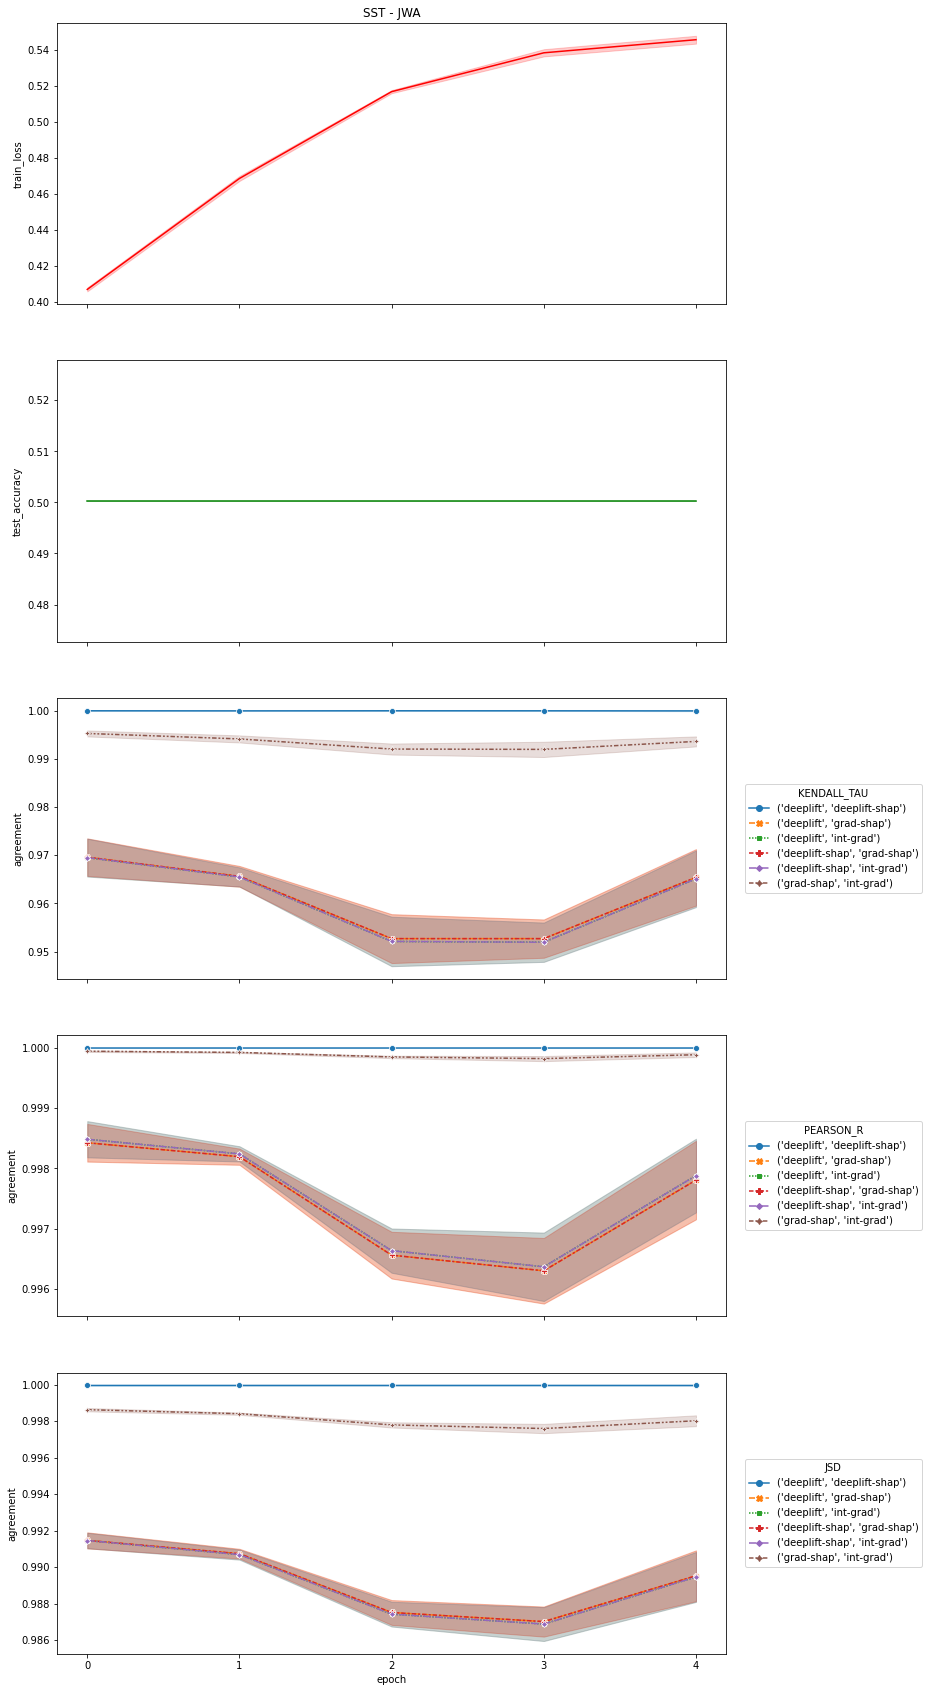

In [17]:
df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(picks[2][0], picks[2][1])
plot_experiment(df_tr, df_agr, picks[2][1])

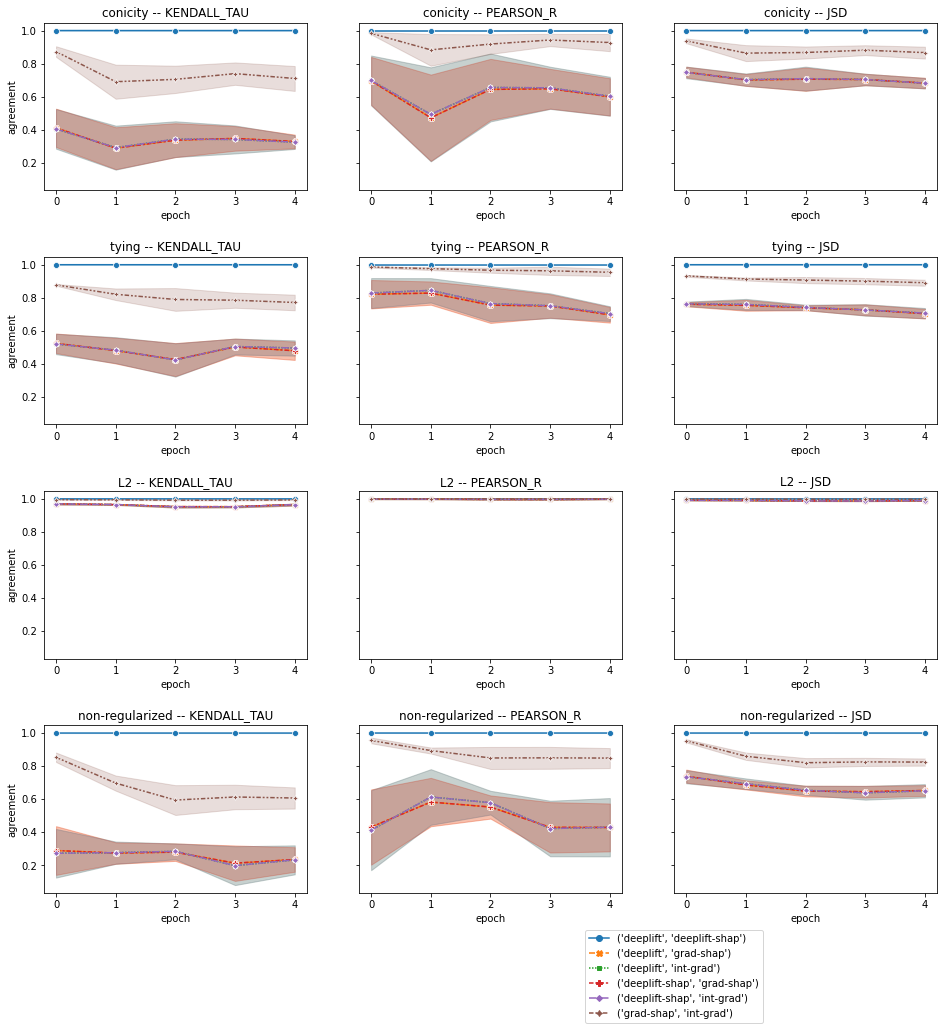

In [8]:
plot_agreement_matrix(picks, ["conicity", "tying", "L2", "non-regularized"])

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.5
Conicity: 0.0
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999706   
           1     (deeplift, deeplift-shap)   0.999625   
           2     (deeplift, deeplift-shap)   0.999460   
           3     (deeplift, deeplift-shap)   0.999670   
           4     (deeplift, deeplift-shap)   0.999639   
...                                               ...   
4          0     (grad-shap, int-grad)       0.738551   
           1     (grad-shap, int-grad)       0.664840   
           2     (grad-shap, int-grad)       0.772750   
           3     (grad-shap, int-grad)       0.744833   
           4     (grad-shap, int-grad

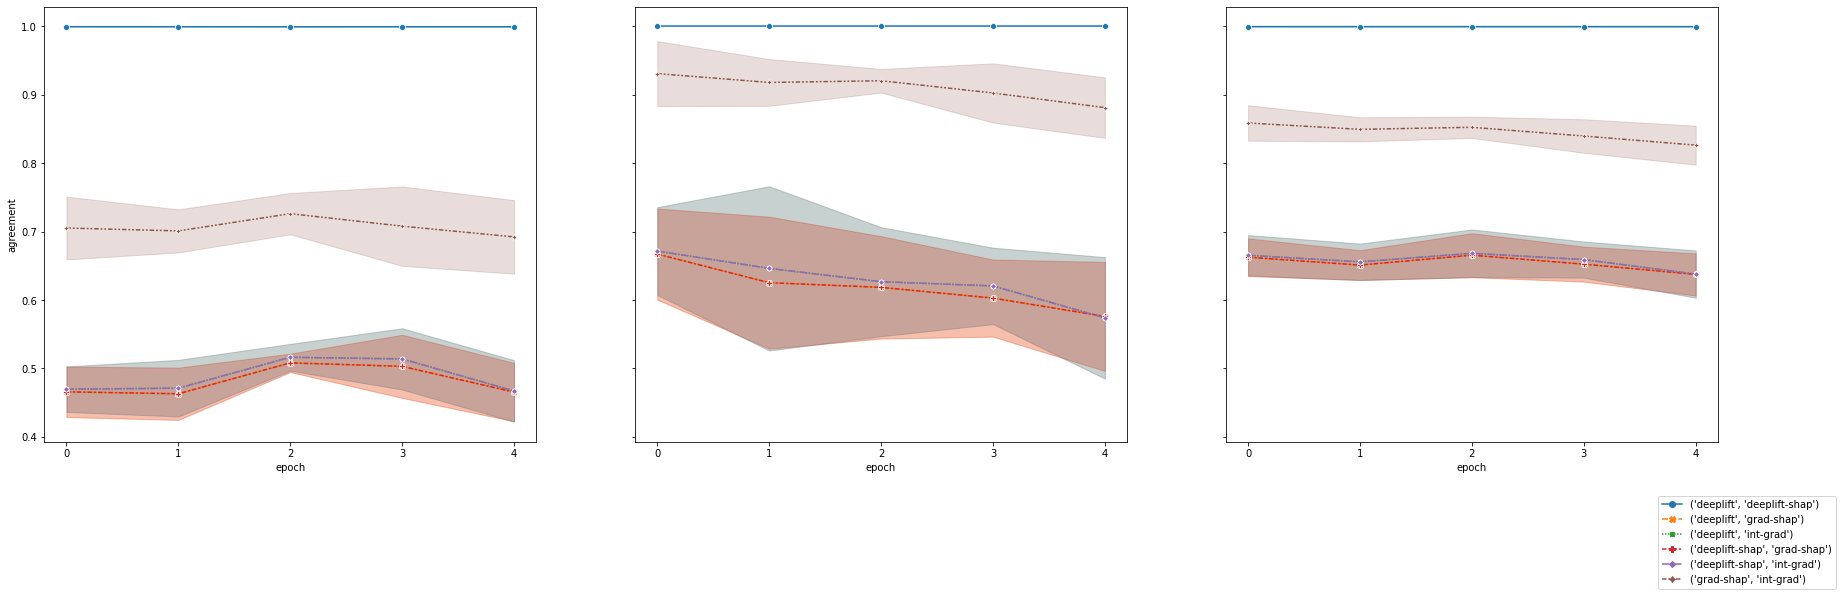

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.1
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999735   
           1     (deeplift, deeplift-shap)   0.999788   
           2     (deeplift, deeplift-shap)   0.999777   
           3     (deeplift, deeplift-shap)   0.999677   
           4     (deeplift, deeplift-shap)   0.999710   
...                                               ...   
4          0     (grad-shap, int-grad)       0.834046   
           1     (grad-shap, int-grad)       0.635259   
           2     (grad-shap, int-grad)       0.709071   
           3     (grad-shap, int-grad)       0.664789   
           4     (grad-shap, int-grad

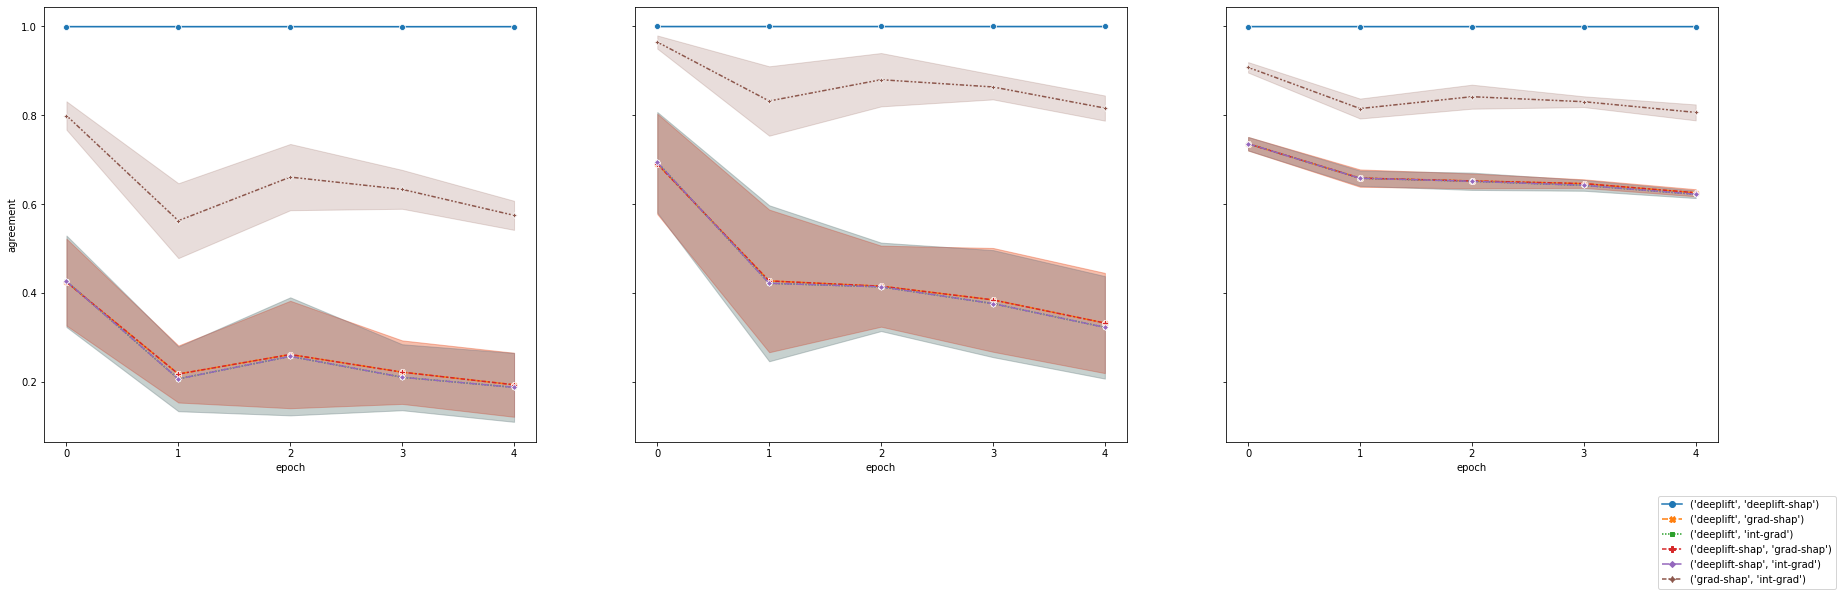

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 1.0
Conicity: 0.0
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999671   
           1     (deeplift, deeplift-shap)   0.999529   
           2     (deeplift, deeplift-shap)   0.999646   
           3     (deeplift, deeplift-shap)   0.999464   
           4     (deeplift, deeplift-shap)   0.999650   
...                                               ...   
4          0     (grad-shap, int-grad)       0.605511   
           1     (grad-shap, int-grad)       0.608136   
           2     (grad-shap, int-grad)       0.745919   
           3     (grad-shap, int-grad)       0.711060   
           4     (grad-shap, int-grad

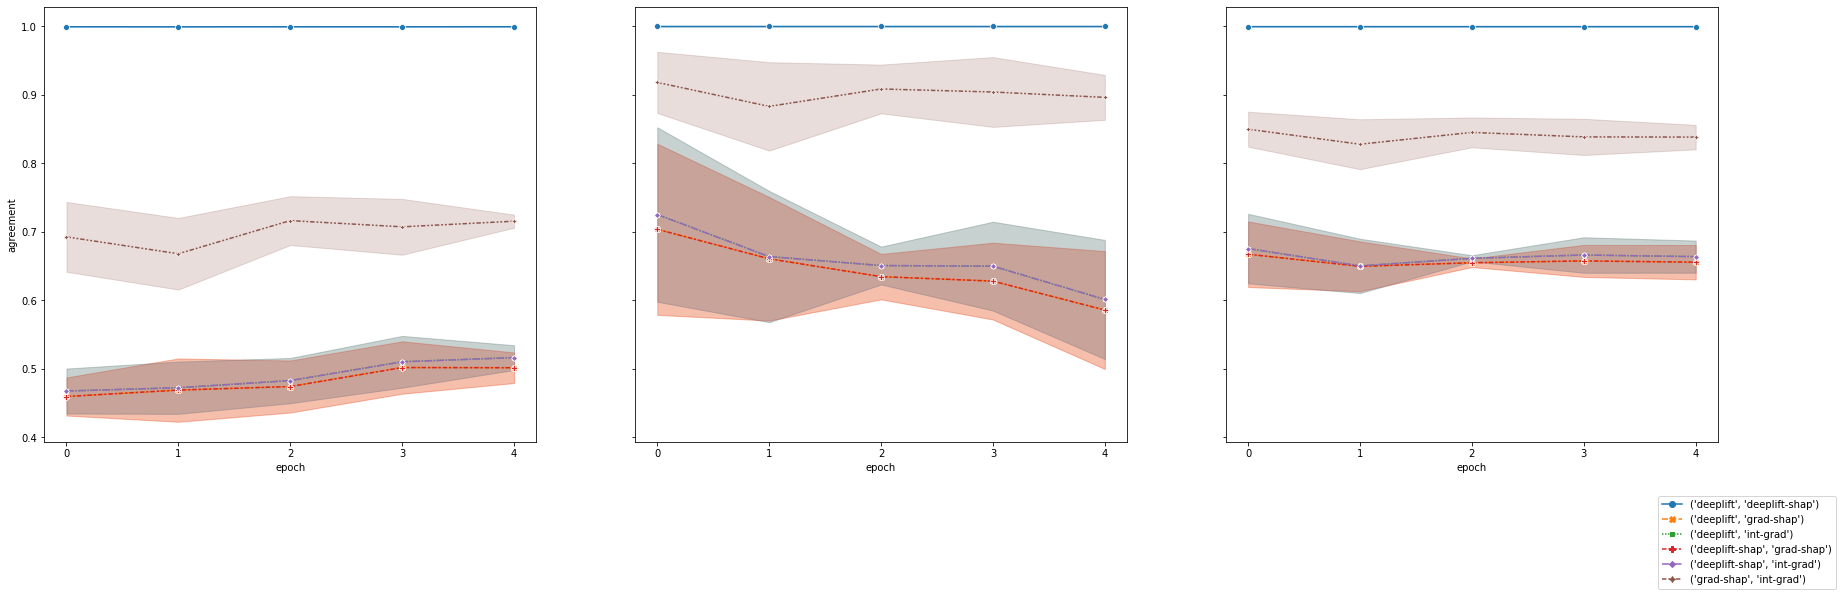

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.0
L2: 0.0001
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999930   
           1     (deeplift, deeplift-shap)   0.999678   
           2     (deeplift, deeplift-shap)   0.999616   
           3     (deeplift, deeplift-shap)   0.999777   
           4     (deeplift, deeplift-shap)   0.999629   
...                                               ...   
4          0     (grad-shap, int-grad)       0.842005   
           1     (grad-shap, int-grad)       0.478328   
           2     (grad-shap, int-grad)       0.880870   
           3     (grad-shap, int-grad)       0.938859   
           4     (grad-shap, int-g

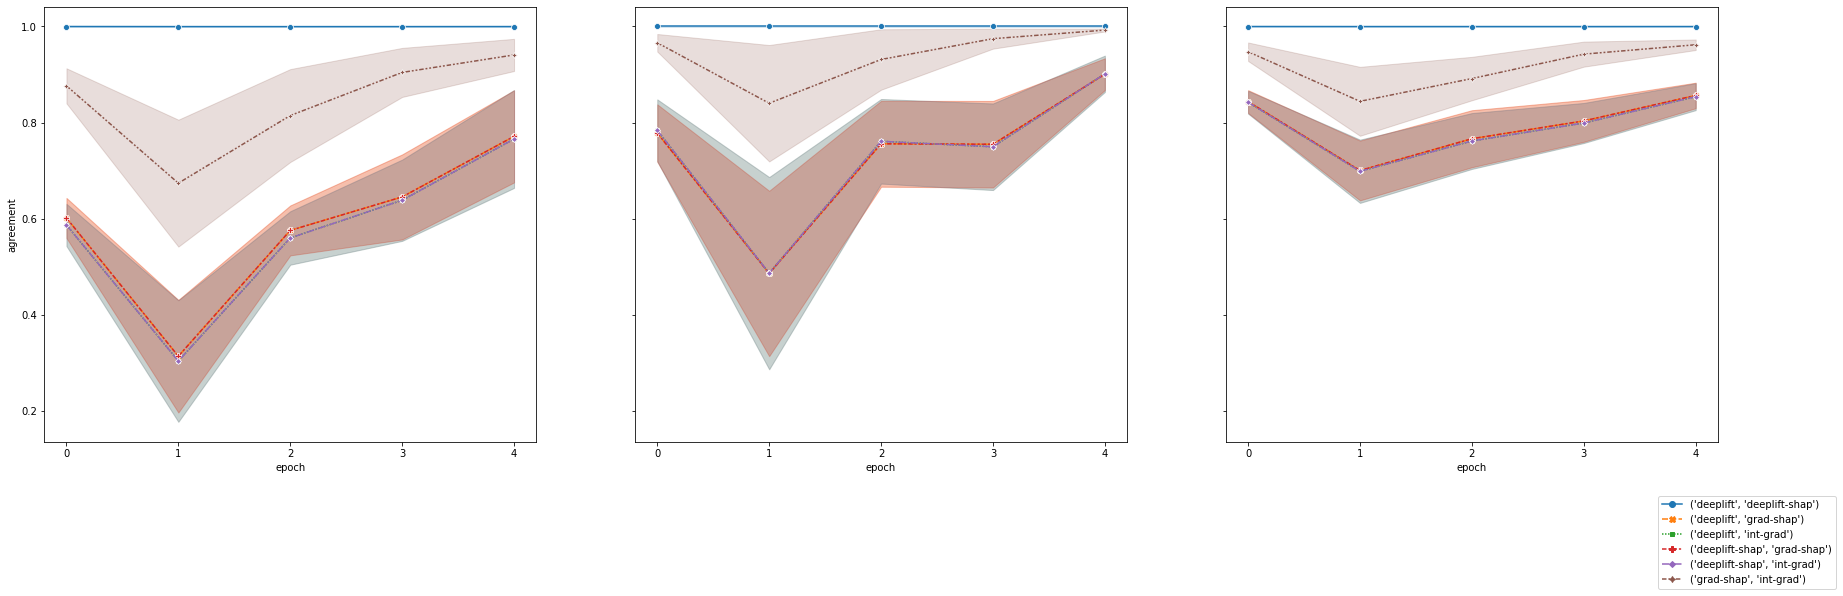

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.1
Conicity: 0.0
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999772   
           1     (deeplift, deeplift-shap)   0.999772   
           2     (deeplift, deeplift-shap)   0.999737   
           3     (deeplift, deeplift-shap)   0.999832   
           4     (deeplift, deeplift-shap)   0.999758   
...                                               ...   
4          0     (grad-shap, int-grad)       0.701724   
           1     (grad-shap, int-grad)       0.775366   
           2     (grad-shap, int-grad)       0.753625   
           3     (grad-shap, int-grad)       0.737192   
           4     (grad-shap, int-grad

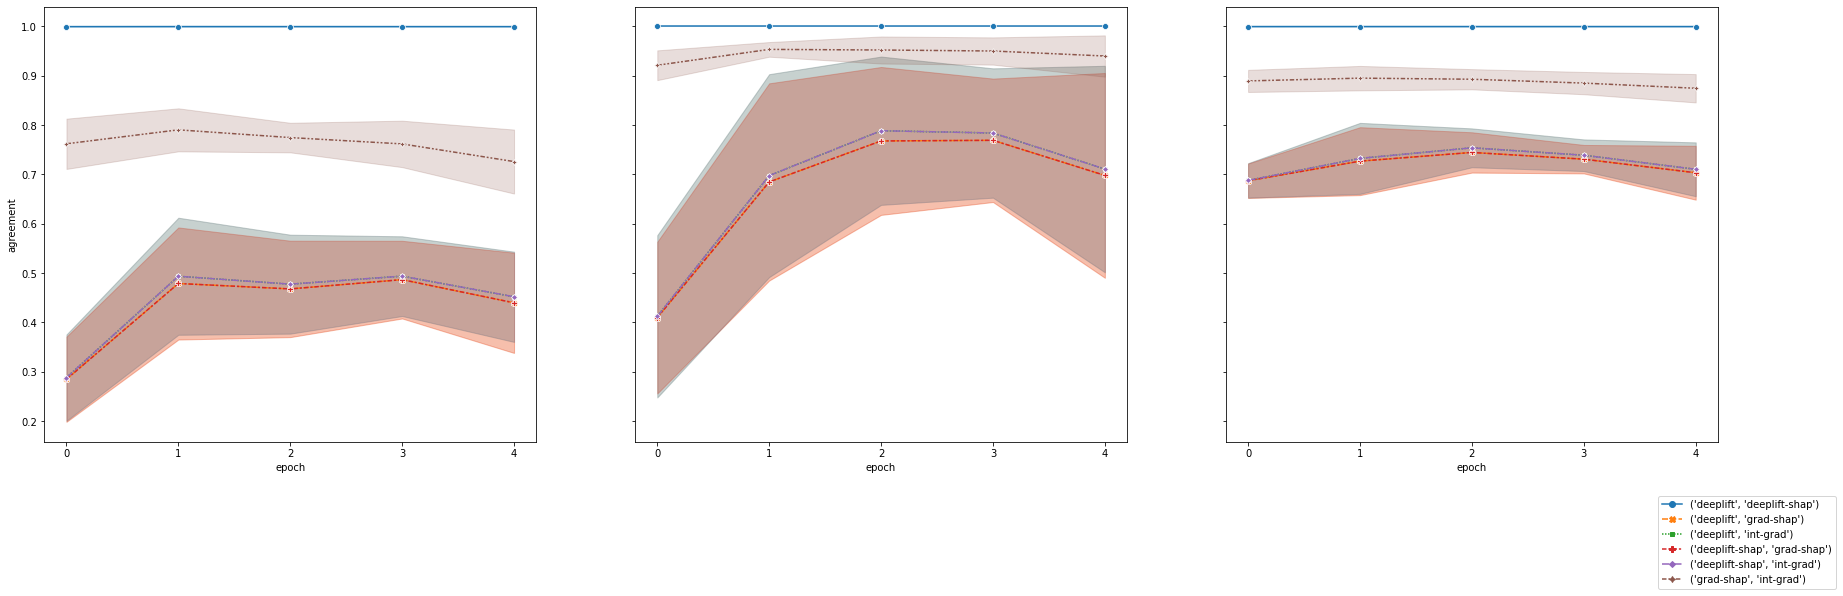

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.5
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999501   
           1     (deeplift, deeplift-shap)   0.999492   
           2     (deeplift, deeplift-shap)   0.999459   
           3     (deeplift, deeplift-shap)   0.999241   
           4     (deeplift, deeplift-shap)   0.999437   
...                                               ...   
4          0     (grad-shap, int-grad)       0.767261   
           1     (grad-shap, int-grad)       0.569038   
           2     (grad-shap, int-grad)       0.572626   
           3     (grad-shap, int-grad)       0.538327   
           4     (grad-shap, int-grad

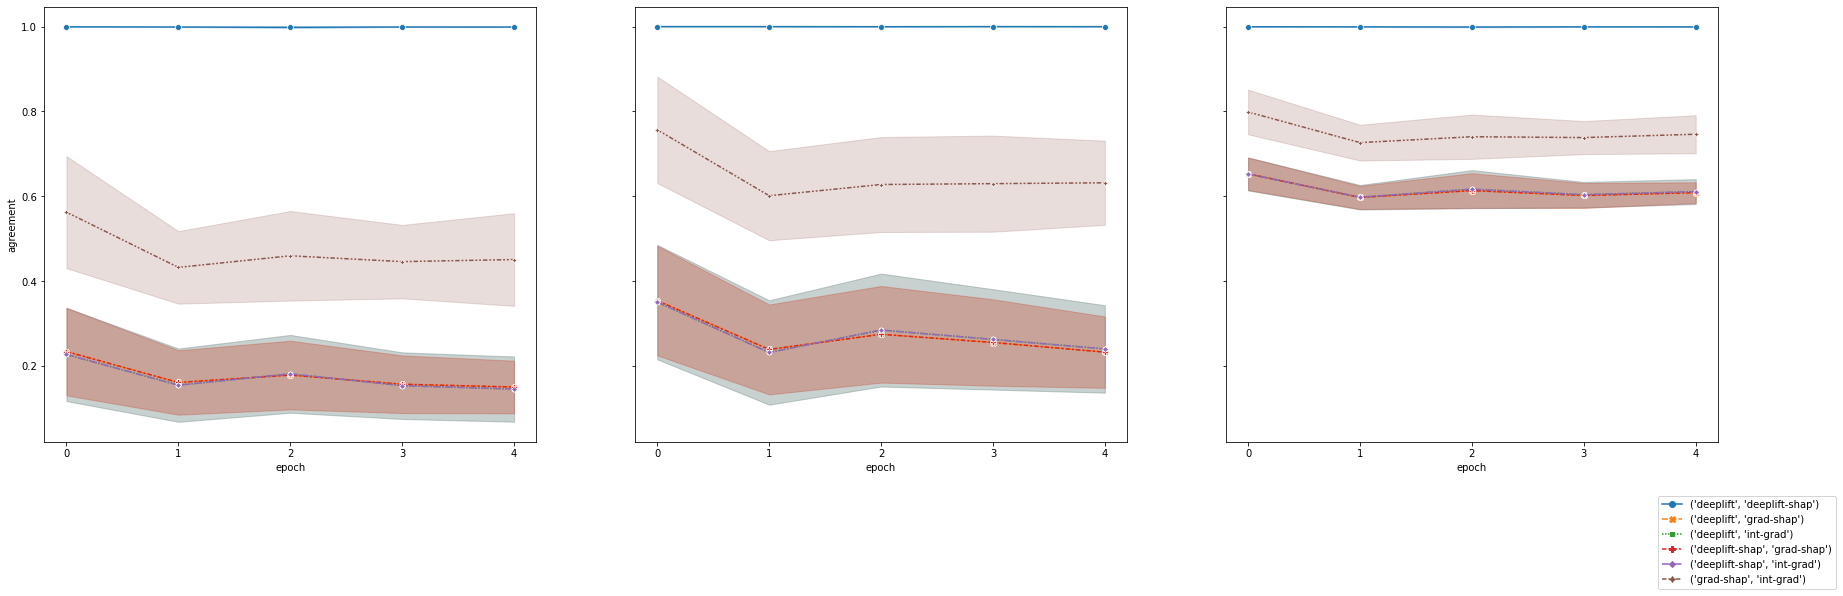

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.0
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999803   
           1     (deeplift, deeplift-shap)   0.999876   
           2     (deeplift, deeplift-shap)   0.999821   
           3     (deeplift, deeplift-shap)   0.999811   
           4     (deeplift, deeplift-shap)   0.999812   
...                                               ...   
4          0     (grad-shap, int-grad)       0.607231   
           1     (grad-shap, int-grad)       0.476957   
           2     (grad-shap, int-grad)       0.477578   
           3     (grad-shap, int-grad)       0.437898   
           4     (grad-shap, int-grad

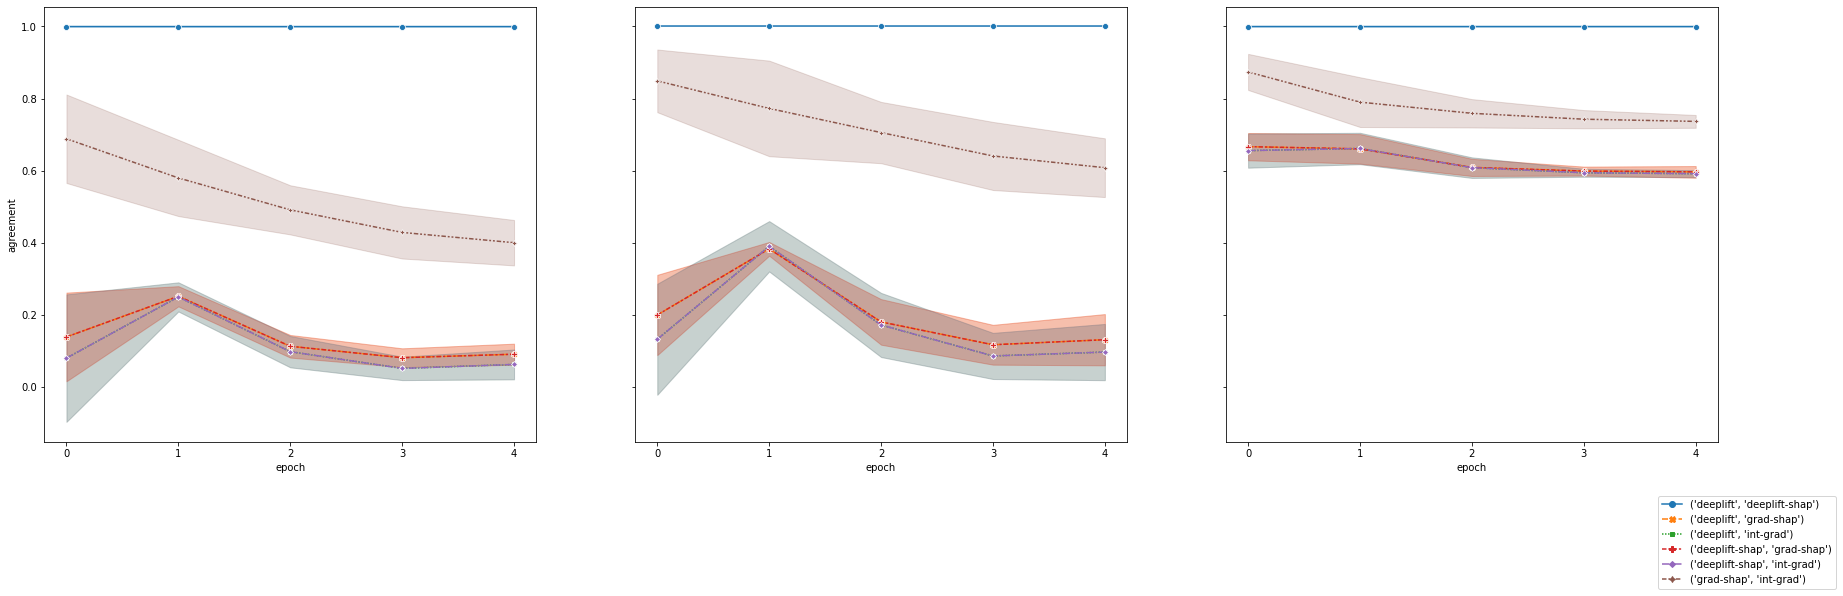

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.3
Conicity: 0.0
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999678   
           1     (deeplift, deeplift-shap)   0.999662   
           2     (deeplift, deeplift-shap)   0.999747   
           3     (deeplift, deeplift-shap)   0.999674   
           4     (deeplift, deeplift-shap)   0.999749   
...                                               ...   
4          0     (grad-shap, int-grad)       0.762776   
           1     (grad-shap, int-grad)       0.761294   
           2     (grad-shap, int-grad)       0.729147   
           3     (grad-shap, int-grad)       0.663233   
           4     (grad-shap, int-grad

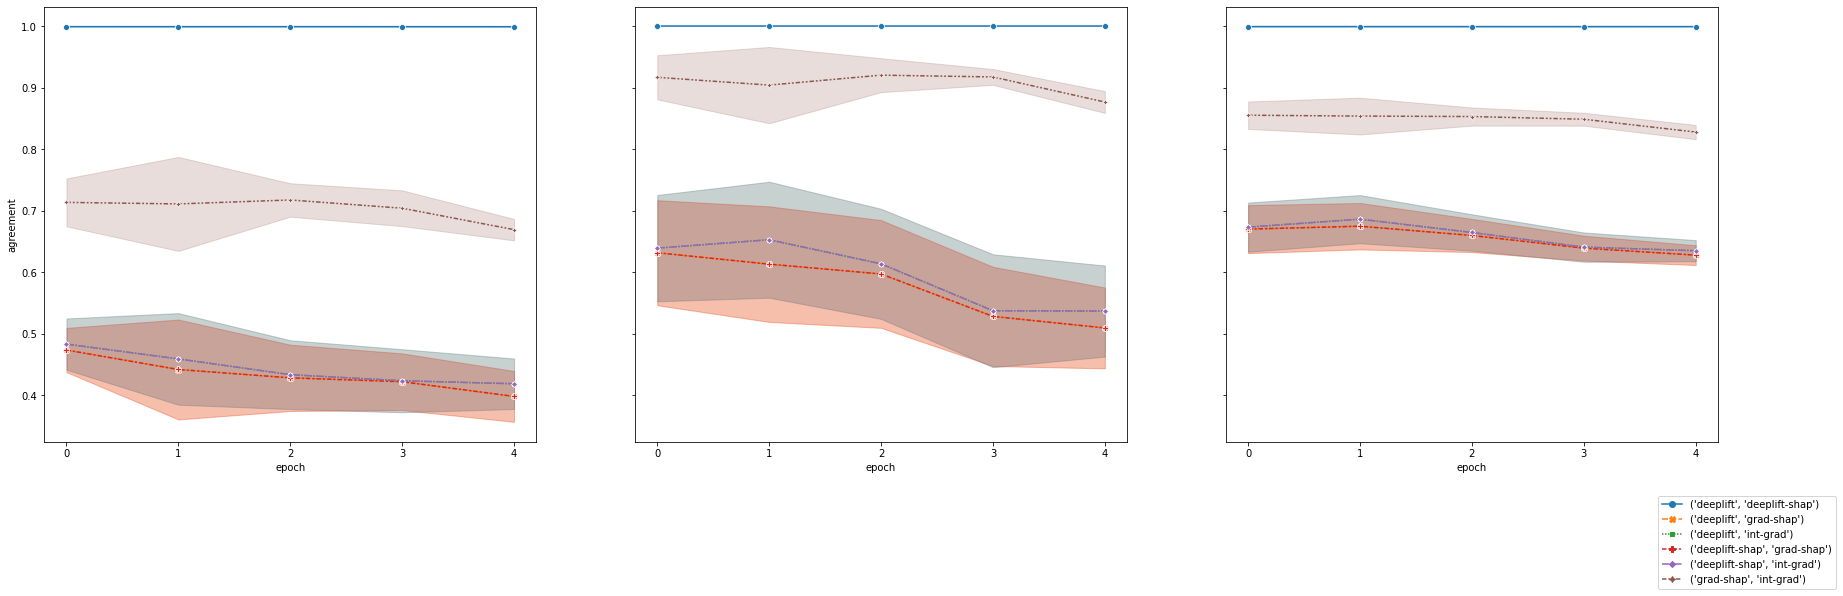

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.0
L2: 0.01
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999959   
           1     (deeplift, deeplift-shap)   0.999943   
           2     (deeplift, deeplift-shap)   0.999957   
           3     (deeplift, deeplift-shap)   0.999930   
           4     (deeplift, deeplift-shap)   0.999945   
...                                               ...   
4          0     (grad-shap, int-grad)       0.997358   
           1     (grad-shap, int-grad)       0.996705   
           2     (grad-shap, int-grad)       0.997842   
           3     (grad-shap, int-grad)       0.997648   
           4     (grad-shap, int-gra

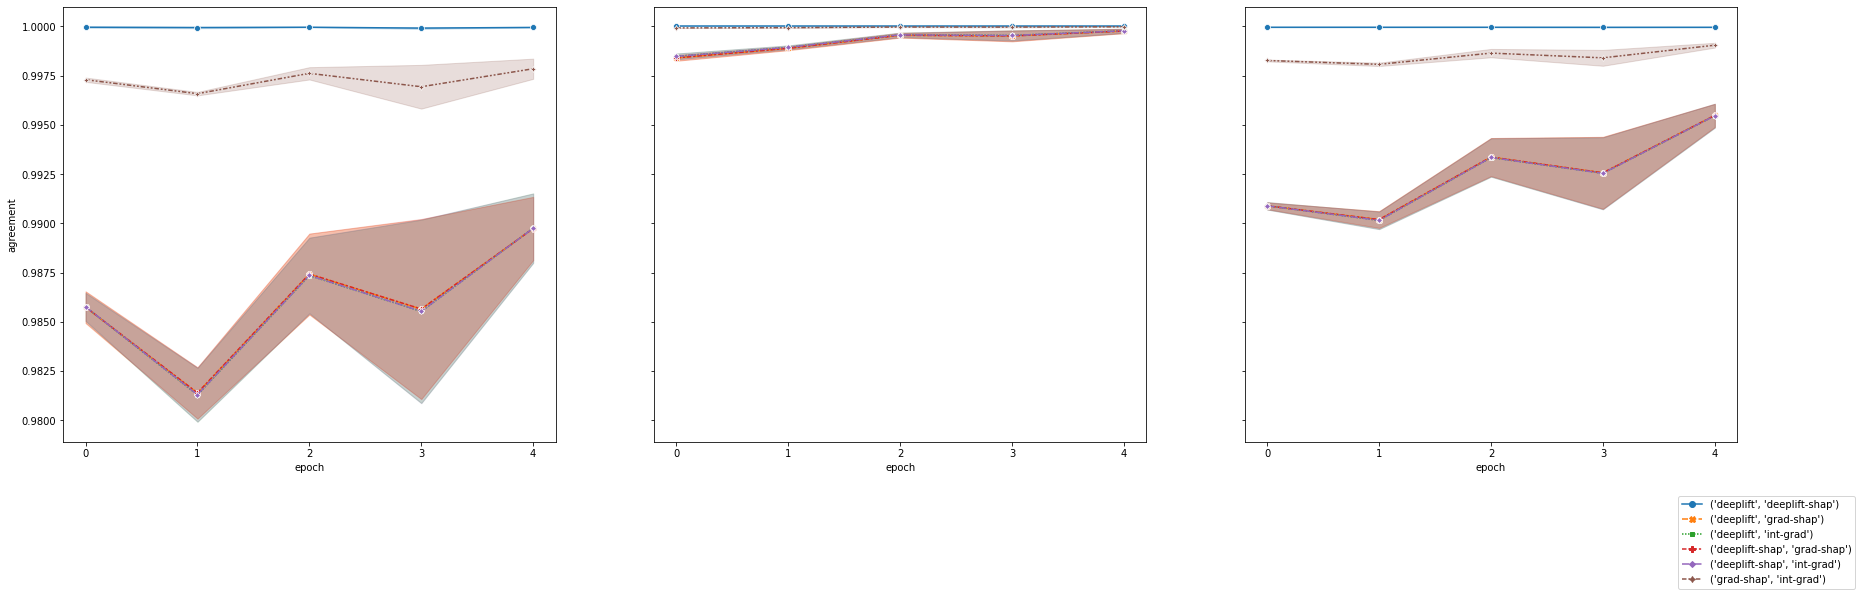

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.0
L2: 0.001
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999943   
           1     (deeplift, deeplift-shap)   0.999950   
           2     (deeplift, deeplift-shap)   0.999930   
           3     (deeplift, deeplift-shap)   0.999892   
           4     (deeplift, deeplift-shap)   0.999804   
...                                               ...   
4          0     (grad-shap, int-grad)       0.958297   
           1     (grad-shap, int-grad)       0.909844   
           2     (grad-shap, int-grad)       0.947454   
           3     (grad-shap, int-grad)       0.973723   
           4     (grad-shap, int-gr

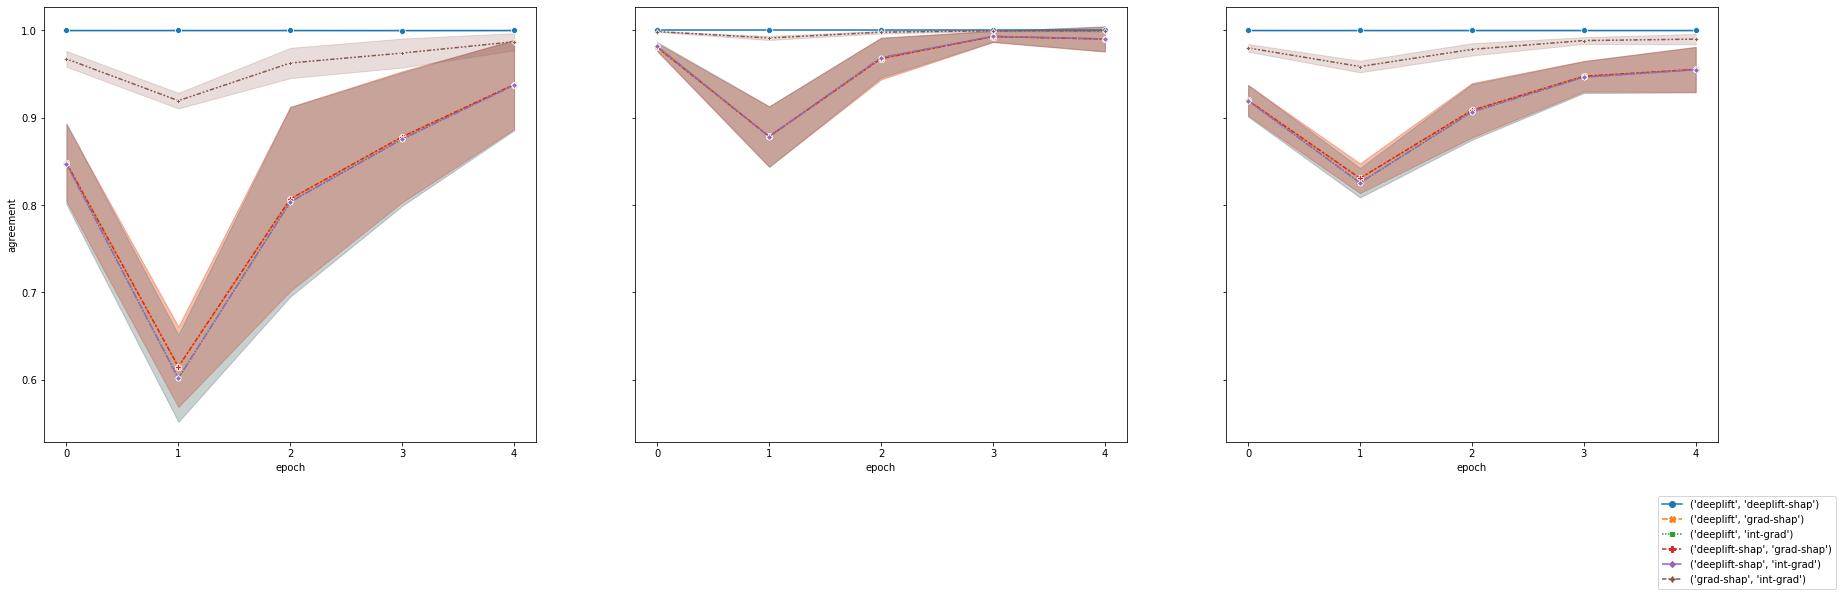

Dataset: SST
Model: JWA
Batch size: 32
Num epochs: 5
Seeds: [1, 2, 3, 4, 5]
Interpreters: ['deeplift', 'deeplift-shap', 'grad-shap', 'int-grad']
Tying: 0.0
Conicity: 0.3
L2: 0.0
----------------------------------------------------------------------------------------------------
                                            agreement  \
experiment epoch interpreter                            
0          0     (deeplift, deeplift-shap)   0.999515   
           1     (deeplift, deeplift-shap)   0.999437   
           2     (deeplift, deeplift-shap)   0.999531   
           3     (deeplift, deeplift-shap)   0.998636   
           4     (deeplift, deeplift-shap)   0.999486   
...                                               ...   
4          0     (grad-shap, int-grad)       0.806093   
           1     (grad-shap, int-grad)       0.738772   
           2     (grad-shap, int-grad)       0.664685   
           3     (grad-shap, int-grad)       0.566419   
           4     (grad-shap, int-grad

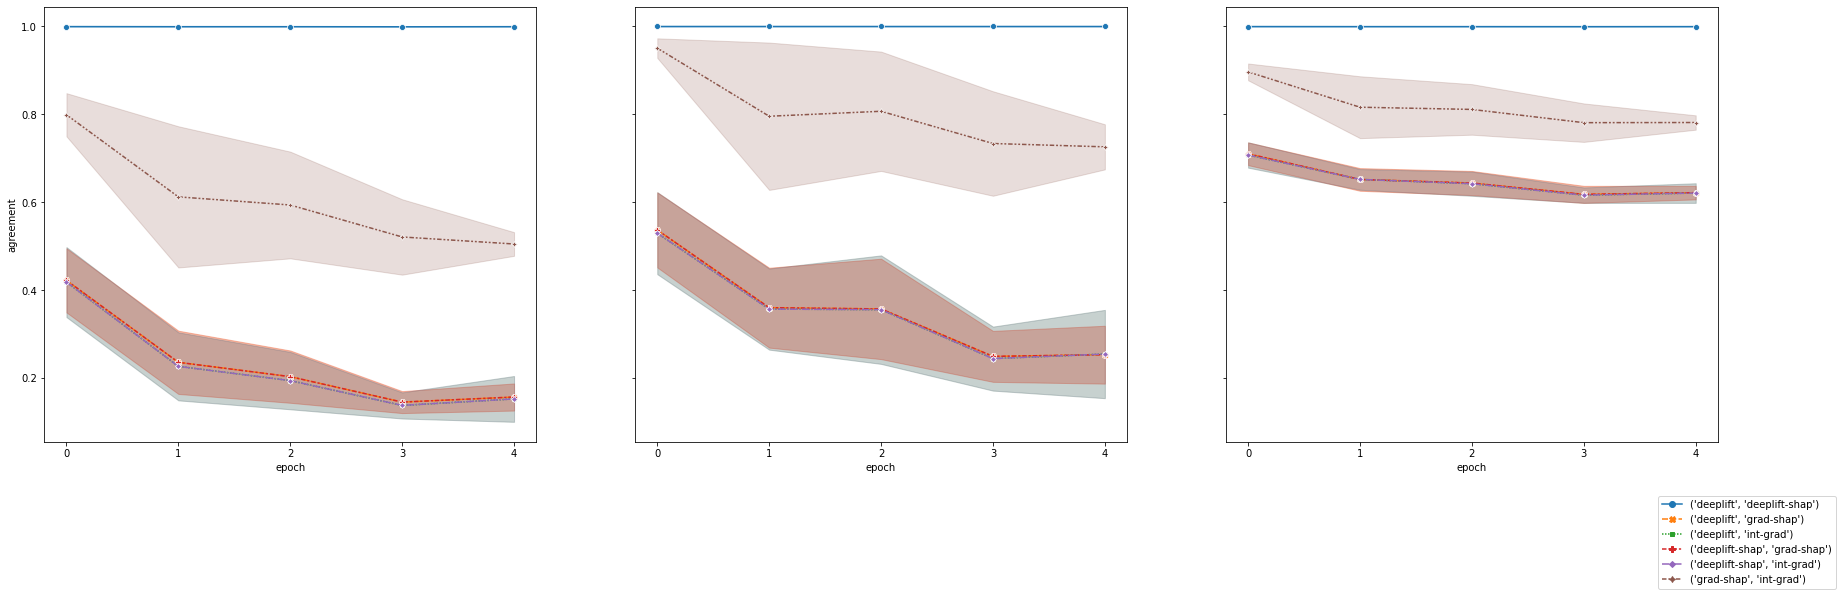

In [6]:
for results, meta in experiments:
    print(f"Dataset: {meta['dataset']}")
    print(f"Model: {meta['model']}")
    print(f"Batch size: {meta['batch_size']}")
    print(f"Num epochs: {meta['epochs_per_train']}")
    print(f"Seeds: {meta['seeds']}")
    print(f"Interpreters: {meta['interpreters']}")
    print(f"Tying: {meta['tying']}")
    print(f"Conicity: {meta['conicity']}")
    print(f"L2: {meta['l2']}")
    print("-" * 100)
    df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
    plot_experiment(df_tr, df_agr, meta)
    plt.show()
    print("=" * 100)

In [9]:
def plot_attribute_matrix(
    experiments,
    figsize=(20, 20),
    attributes=[
        "correctness",
        "confidence",
        "variability",
        "forgetfulness",
        "threshold_closeness",
    ],
    print_flag=False,
):
    fig, axs = plt.subplots(
        len(experiments), len(attributes) + 1, figsize=figsize, sharex=True
    )
    fig.subplots_adjust(wspace=0.25)
    for j, (results, meta) in enumerate(experiments):
        df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(results, meta)
        df_crt_avg = cartography_average(df_crt_test)
        dfs = []
        for corr_meas, df_agr_i in df_agr.items():
            df_agr_avg = agreement_average(df_agr_i)

            corr_vals = []
            for (epoch, ip), row in df_agr_avg.iterrows():
                if epoch != meta["epochs_per_train"] - 1:
                    continue
                if print_flag:
                    print(f"Epoch {epoch}")
                    print("=" * 100)
                    print(f"\tInterpreter pair: {ip}")
                for key in attributes:
                    corr = pearsonr(row["correlation"], df_crt_avg[key])
                    val = {
                        "interpreter": ip,
                        "epoch": epoch,
                        "correlation": corr[0],
                        "p-value": corr[1],
                        "attribute": key,
                    }
                    corr_vals.append(val)
                    if print_flag:
                        print(f"\t\t agreement vs. {key}: {corr}")

                corr = pearsonr(row["correlation"], meta["test_lengths"])
                val = {
                    "interpreter": ip,
                    "epoch": epoch,
                    "correlation": corr[0],
                    "p-value": corr[1],
                    "attribute": "length",
                }
                corr_vals.append(val)
                if print_flag:
                    print(f"\t\t agreement vs. length: {corr}")
                    print()

            df = pd.DataFrame(corr_vals)
            df["measure"] = corr_meas
            dfs.append(df)

        major_df = pd.concat(dfs)
        ips = meta["interpret_pairs"]

        for i, attribute in enumerate(attributes + ["length"]):
            df_filt = major_df[major_df.attribute == attribute]
            axs[j][i].set_title(attribute)
            g = sns.barplot(
                ax=axs[j][i],
                data=df_filt,
                x="interpreter",
                y="correlation",
                hue="measure",
                ci="sd",
                palette="dark",
                alpha=0.75,
            )
            g.set_title(attribute)
            g.set_xticklabels(
                rotation=30, labels=ips, ha="right", rotation_mode="anchor"
            )

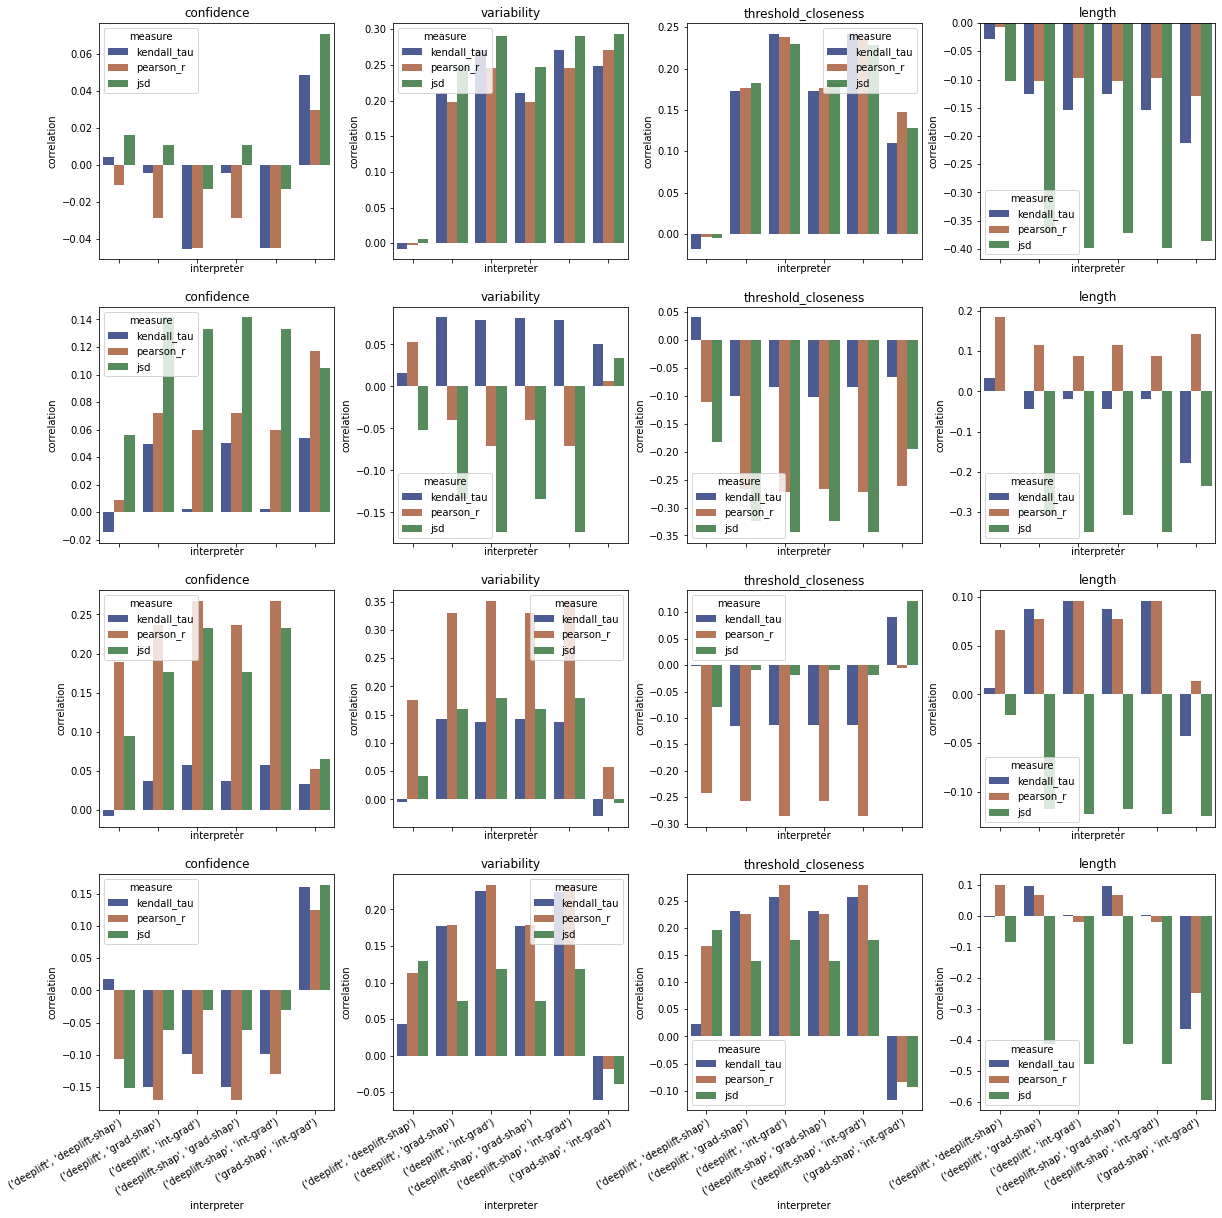

In [217]:
plot_attribute_matrix(
    picks, attributes=["confidence", "variability", "threshold_closeness"]
)

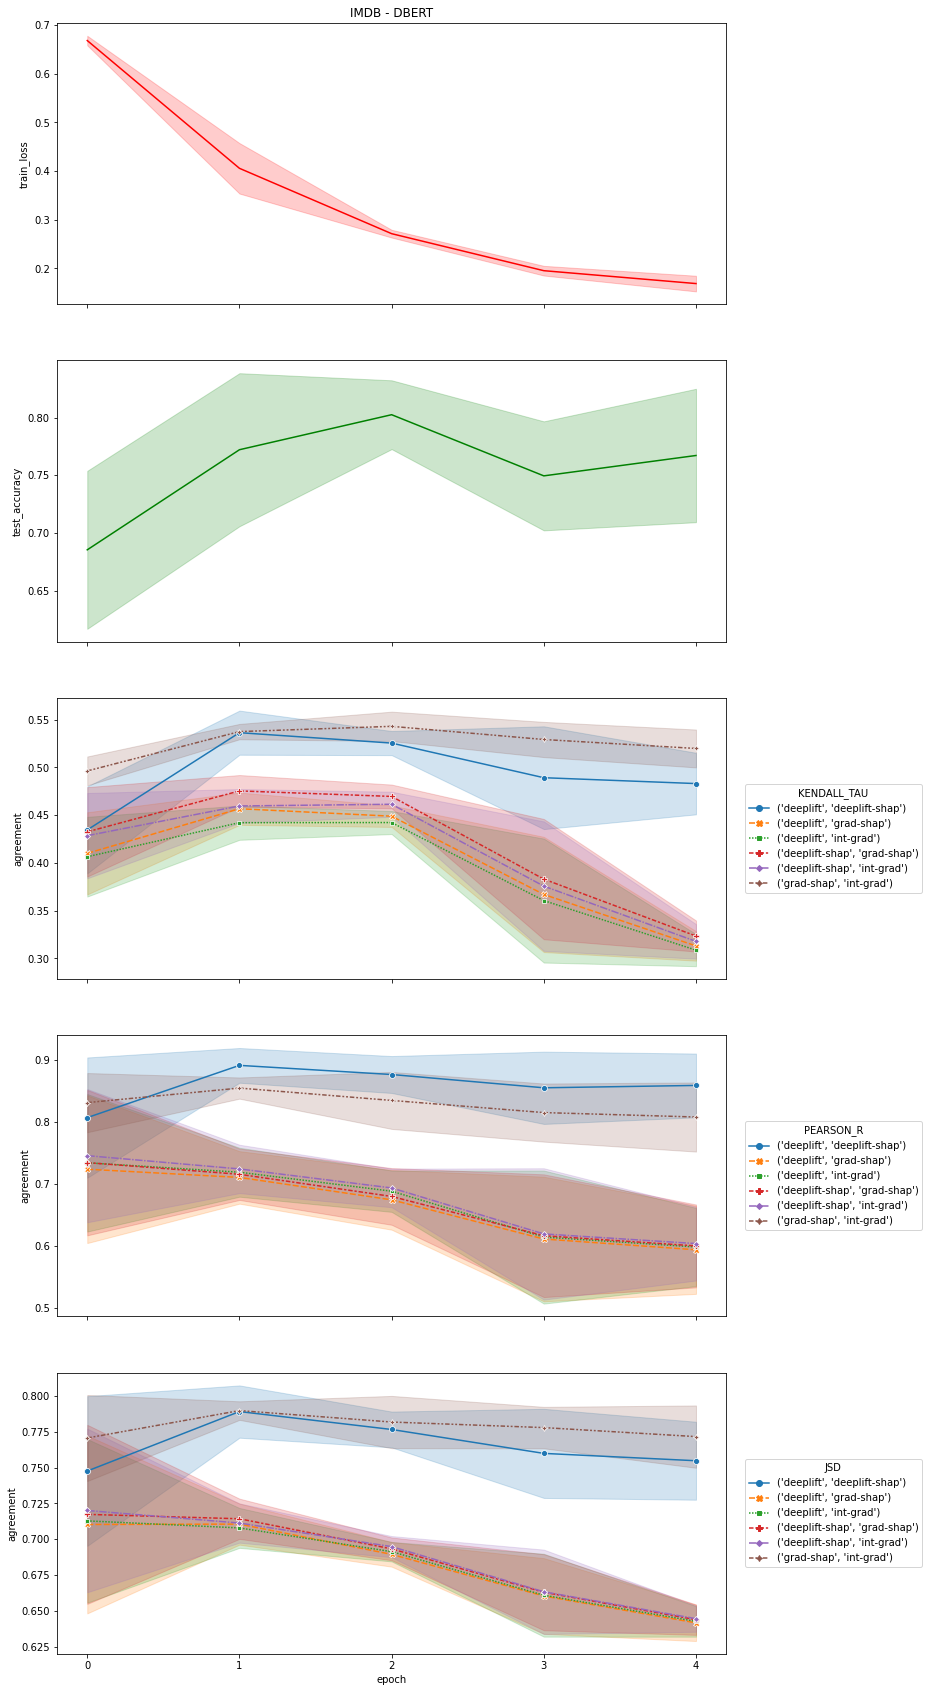

In [7]:
df_tr, df_agr, df_crt_train, df_crt_test, df_attr = results_to_df(experiments[0][0], experiments[0][1])
plot_experiment(df_tr, df_agr, experiments[0][1])

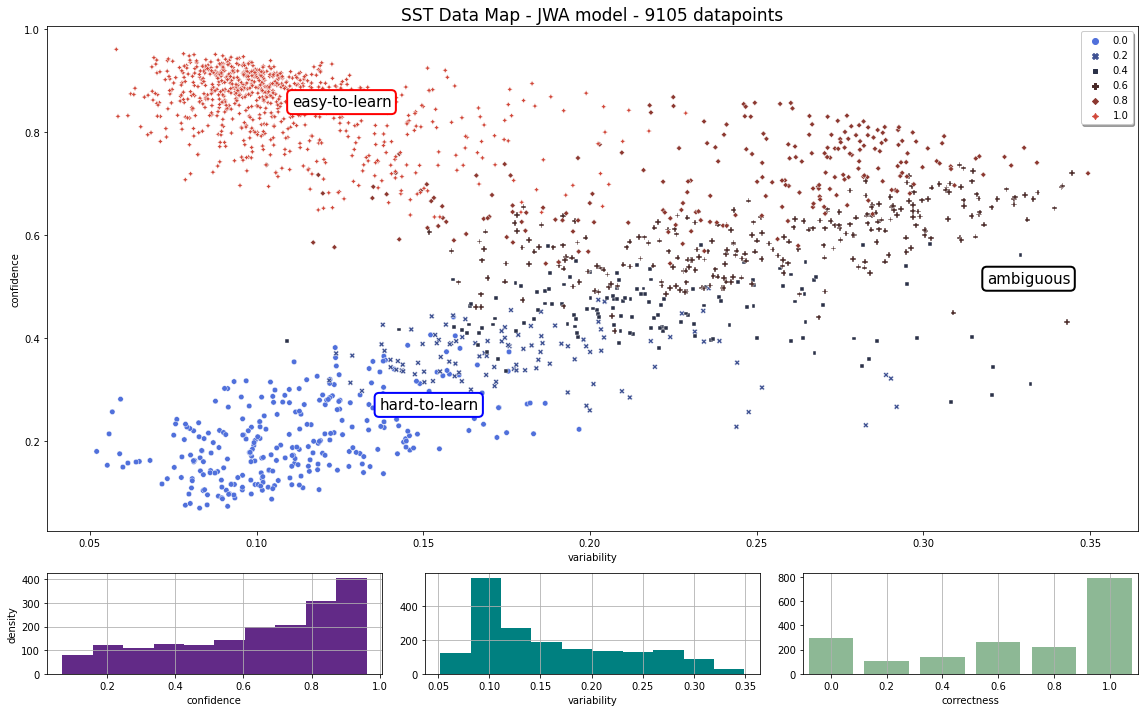

In [153]:
fig = plot_cartography(df_crt_test, meta, hue_metric="correct")

In [ ]:
(train, val, test), vocab = load_imdb_sentences(clip=False)
test = test[meta["test_mapping"]]

In [15]:
corr_meas = "pearson_r"

In [17]:
df_c = df_crt_test[df_crt_test.index.get_level_values("experiment") == 0]
df_agr_i = df_agr[corr_meas]
df_a = df_agr_i[(df_agr_i.index.get_level_values("experiment") == 0) & (df_agr_i.index.get_level_values("epoch") == 4)]
df_t = df_attr[(df_attr.index.get_level_values("experiment") == 0) & (df_attr.index.get_level_values("epoch") == 4)]
df_t = df_t.reset_index().set_index("example")
correctness = df_c.correctness.to_numpy()

In [18]:
ip = ("deeplift", "grad-shap")

In [ ]:
texts = []
tokens = []
types = []
labels = []

# LABEL_MAP = {"1": "positive", "0": "negative"}
LABEL_MAP = {"positive": "positive", "negative": "negative"}
for i, ex in enumerate(test):
    texts.append(ex.text[0])
    toks = ex.text[1]
    tokens.append(toks)
    labels.append(LABEL_MAP[ex.label[1]])


df_text = pd.DataFrame(
    {
        "text": texts,
        "tokens": tokens,
        "label": labels,
        "correct": df_c.correctness,
        "(deeplift, grad-shap)": df_a.iloc[0].correlation,
        "(deeplift, int-grad)": df_a.iloc[1].correlation,
        "(grad-shap, int-grad)": df_a.iloc[2].correlation,
    }
)
df_text = df_text.reset_index().set_index("example")
df_exs = pd.concat([df_text, df_t], axis=1)

In [9]:
ip_str = "(deeplift, grad-shap)"


d1 = df_exs.sort_values(ip_str)[:10]
d2 = df_exs.sort_values(ip_str)[-10:]
d12 = pd.concat([d1, d2])

In [10]:
d12

,experiment,text,tokens,label,correct,"(deeplift, grad-shap)","(deeplift, int-grad)","(grad-shap, int-grad)",experiment,epoch,deeplift,grad-shap,int-grad
example,,,,,,,,,,,,,
3183,0,the narrative was clear and concise but overal...,"[the, narrative, was, clear, and, concise, but...",negative,4,0.080363,0.094340,0.664570,0,4,"[1.1087511e-06, 6.659208e-05, 1.5760963e-06, 3...","[0.0027720581, 0.23038872, 0.0073456876, 0.003...","[0.027495517356517625, 0.4210102856822742, 0.0..."
1521,0,take my suggestion and do not see this movie u...,"[take, my, suggestion, and, do, not, see, this...",negative,4,0.123874,0.137387,0.529601,0,4,"[2.4818041e-06, 4.110574e-07, 1.5895905e-06, 9...","[0.027695337, 0.0005463781, 0.03364306, 0.2214...","[0.004144048873531595, 0.010638403890669194, 0..."
268,0,they took a slick very sophisticated show and ...,"[they, took, a, slick, very, sophisticated, sh...",positive,4,0.127180,0.189680,0.544089,0,4,"[5.612668e-06, 2.8469137e-07, 8.6978895e-07, 3...","[0.0057931803, 0.05070868, 0.017784266, 0.2073...","[0.017162186198027347, 0.0391364833952382, 0.0..."
1495,0,a little slow and grabbing for attention at ti...,"[a, little, slow, and, grabbing, for, attentio...",positive,4,0.151539,0.171531,0.523657,0,4,"[4.768504e-06, 5.3854336e-07, 1.2263988e-07, 8...","[0.10207464, 0.020817809, 0.0028137092, 0.0167...","[0.11075287780339485, 0.001737072071194743, 0...."
690,0,after some complains father nazario decide to ...,"[after, some, complains, father, nazario, deci...",positive,4,0.158143,0.255180,0.583006,0,4,"[3.7494756e-06, 3.0349911e-05, 4.2476415e-07, ...","[0.00080603163, 0.06293791, 0.009889896, 0.000...","[0.008997530357785484, 0.18596185518708375, 0...."
1035,0,we like the hero will never escape from the su...,"[we, like, the, hero, will, never, escape, fro...",positive,5,0.188811,0.243201,0.618881,0,4,"[6.692226e-07, 2.389399e-07, 1.756625e-07, 4.8...","[0.015063508, 0.009145943, 0.008522635, 0.1438...","[0.01588074133050537, 0.03040939804854649, 0.0..."
2329,0,he walks her home,"[he, walks, her, home]",positive,5,0.192812,0.349865,0.536029,0,4,"[6.5947124e-06, 1.3898364e-07, 2.3642726e-06, ...","[0.0071048583, 0.02794072, 0.039942894, 0.0006...","[0.027992041119414397, 0.03911222917091711, 0...."
4205,0,my whole family loved to watch the show,"[my, whole, family, loved, to, watch, the, show]",positive,4,0.193287,0.213066,0.667765,0,4,"[2.242939e-05, 7.792484e-08, 3.5419794e-07, 6....","[0.095940836, 0.030728195, 0.013820344, 0.0190...","[0.0929231289930792, 0.005673395742351043, 0.0..."
1942,0,this movie contained an all star cast and what...,"[this, movie, contained, an, all, star, cast, ...",positive,4,0.198928,0.233148,0.595547,0,4,"[1.1076896e-05, 2.7781377e-06, 8.4961005e-07, ...","[0.026296271, 0.08078034, 0.019278703, 0.04176...","[0.0014630055480569352, 0.0899454635993828, 0...."


In [11]:
import matplotlib
from spacy import displacy
from sklearn.preprocessing import MinMaxScaler as MMS
from sklearn.preprocessing import normalize
from scipy.stats import kendalltau
from scipy.stats import rankdata


TPL_TOK = """
<mark class="entity" style="background: {bg}; padding: 0.45em 0.6em; margin: 0 0.05em; line-height: 1; border-radius: 0.01em; box-decoration-break: clone; -webkit-box-decoration-break: clone">
    {text}
</mark>
"""

cmap = sns.color_palette("coolwarm", as_cmap=True)


def example_viz(example, interpreter="deeplift"):
    mms = MMS((0, 256))
    colors = (
        mms.fit_transform(example[interpreter].reshape(-1, 1)).ravel().astype(np.int32)
    )
    colors = {
        str(i): matplotlib.colors.to_hex(cmap(c), keep_alpha=True)
        for i, c in enumerate(colors)
    }

    ents = []
    ii = 0
    for itok in range(len(example.tokens)):
        ff = ii + len(example.tokens[itok])
        ent = {
            "start": ii,
            "end": ff,
            "label": str(itok),
        }
        ents.append(ent)
        ii = ff

    to_render = {
        "text": "".join(example.tokens),
        "ents": ents,
    }

    html = displacy.render(
        to_render,
        style="ent",
        manual=True,
        jupyter=True,
        options={"colors": colors, "template": TPL_TOK},
    )

    return html


def norm(v):
    return normalize(v.reshape(-1, 1)).ravel()


def example_agreement_viz(example, interpret_pair):
    mms = MMS((0, 256))
    w1 = example[interpret_pair[0]]
    w2 = example[interpret_pair[1]]
    r1 = rankdata(-w1, method="ordinal")
    r2 = rankdata(-w2, method="ordinal")
    tau, p_value = kendalltau(w1, w2)
    print(f"Agreement {interpret_pair}: [Kendall's tau = {tau}] [p-val = {p_value}]")
    agreement = w1.size - np.fabs(r1 - r2)
    colors = mms.fit_transform(agreement.reshape(-1, 1)).ravel().astype(np.int32)
    colors = {
        str(i): matplotlib.colors.to_hex(cmap(c), keep_alpha=True)
        for i, c in enumerate(colors)
    }

    ents = []
    ii = 0
    for itok in range(len(example.tokens)):
        ff = ii + len(example.tokens[itok])
        ent = {
            "start": ii,
            "end": ff,
            "label": str(itok),
        }
        ents.append(ent)
        ii = ff

    to_render = {
        "text": "".join(example.tokens),
        "ents": ents,
    }

    html = displacy.render(
        to_render,
        style="ent",
        manual=True,
        jupyter=True,
        options={"colors": colors, "template": TPL_TOK},
    )

    return html


ip = ("deeplift", "grad-shap")


for ind, i in enumerate(range(len(d12))):
    ex = d12.iloc[i]
    print(f"Example no. {ind}")
    print("-" * 100)
    print(ex.text)
    print()
    print(f"Sentiment: {ex.label}")
    print(f"Cartography: {ex.correct}")
    print("-" * 100)
    for interpreter in ["deeplift", "grad-shap"]:
        print(f"Interpreter: {interpreter}")
        example_viz(ex, interpreter=interpreter)
        print("-" * 100)
    
#     print(f"Aggrement between {ip}")
    example_agreement_viz(d12.iloc[i], ip)

Example no. 0
----------------------------------------------------------------------------------------------------
the narrative was clear and concise but overall the film never caught my interest- scenes felt flat and uninspired ghengis khan historically speaking had a very interesting epic life but the film failed to capture that- instead focused on small skirmishes as a youth and a love story i think i 've seen disguised in a slew of other films

Sentiment: negative
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.08036338225017468] [p-val = 0.3909221700568224]


Example no. 1
----------------------------------------------------------------------------------------------------
take my suggestion and do not see this movie unless you plan on falling asleep

Sentiment: negative
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.12387387387387384] [p-val = 0.05284947670453185]


Example no. 2
----------------------------------------------------------------------------------------------------
they took a slick very sophisticated show and dropped it down to the level of sesame street

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.12718023255813954] [p-val = 0.032540667720903575]


Example no. 3
----------------------------------------------------------------------------------------------------
a little slow and grabbing for attention at time i wish that nathaniel would have focused a little more on his father 's work than his family drama although much of the history was interesting louis was a bit of a player).<br /><br />this really is a journey through someone 's life and i was happy to tag along for the experience

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.15153938424630145] [p-val = 0.012934126194122542]


Example no. 4
----------------------------------------------------------------------------------------------------
after some complains father nazario decide to be with them discovering with some things until the end how he feels about faith god religion and the person in necessity the people who must request to charity to survive

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.15814319433516913] [p-val = 0.009195120856798212]


Example no. 5
----------------------------------------------------------------------------------------------------
we like the hero will never escape from the suffocating intensity and paradoxical monotony of his criminally driven mafia world

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1888111888111888] [p-val = 0.0007857727403246599]


Example no. 6
----------------------------------------------------------------------------------------------------
he walks her home

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1928122192273136] [p-val = 0.0033976563046110428]


Example no. 7
----------------------------------------------------------------------------------------------------
my whole family loved to watch the show

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.19328738387773448] [p-val = 0.0006429218960644461]


Example no. 8
----------------------------------------------------------------------------------------------------
this movie contained an all star cast and what i loved the most was that it opened my eyes to see other actors who i have n't seen before

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.1989280560709132] [p-val = 0.0035304695240504975]


Example no. 9
----------------------------------------------------------------------------------------------------
though not exceedingly complex the cute story holds your attention and keeps you laughing the whole way through

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.20011788977306216] [p-val = 0.0013790197503408678]


Example no. 10
----------------------------------------------------------------------------------------------------
fine performances by halle berry sabina lloyd and brian bonsall two really fun over the top ones by diane ladd and michael ironside,<br /><br />and a downright outstanding one from patrick swayze

Sentiment: positive
Cartography: 1
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7256140350877194] [p-val = 1.7813163791569184e-20]


Example no. 11
----------------------------------------------------------------------------------------------------
overall all the actor 's were very good

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7259001161440186] [p-val = 1.2581808195268375e-11]


Example no. 12
----------------------------------------------------------------------------------------------------
fans of horror films must see this

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7270588235294119] [p-val = 5.101708003849974e-14]


Example no. 13
----------------------------------------------------------------------------------------------------
most of the pantomime and acting is much broader than it needs to be for a slapstick comedy even hardy already a very subtle actor by 1925 pongs badly with his over acting here

Sentiment: negative
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7327327327327328] [p-val = 1.7422683420145513e-10]


Example no. 14
----------------------------------------------------------------------------------------------------
advise to return back to civilization

Sentiment: positive
Cartography: 5
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7327327327327328] [p-val = 1.7422683420145513e-10]


Example no. 15
----------------------------------------------------------------------------------------------------
now to me if the painting showed things that had indeed happened why would the great doctor believe that he could somehow change what was going to happen

Sentiment: negative
Cartography: 3
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7352657004830918] [p-val = 5.79316993744103e-13]


Example no. 16
----------------------------------------------------------------------------------------------------
since they are wearing german uniforms they wore them to blow up the dump they tie a white flag around a stick and walk out into the road.<br /><br />some british guy walks up behinds them and machine guns them to death

Sentiment: negative
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7393483709273184] [p-val = 4.5501781152661215e-16]


Example no. 17
----------------------------------------------------------------------------------------------------
for those interested in race relations in the united states and the actual workings of law enforcement and the legal process it 's well worth your time and effort to find this documentary

Sentiment: positive
Cartography: 2
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7497231450719822] [p-val = 1.3895428238366597e-12]


Example no. 18
----------------------------------------------------------------------------------------------------
working girl kitty sothern is engaged to bill kelly who neglects her by working long hours at his garage in order to save money for their marriage

Sentiment: positive
Cartography: 4
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.7543859649122808] [p-val = 1.1501949653633416e-16]


Example no. 19
----------------------------------------------------------------------------------------------------
there 's a notable lack of dramatic tension to this meandering three hour miniseries

Sentiment: negative
Cartography: 2
----------------------------------------------------------------------------------------------------
Interpreter: deeplift


----------------------------------------------------------------------------------------------------
Interpreter: grad-shap


----------------------------------------------------------------------------------------------------
Agreement ('deeplift', 'grad-shap'): [Kendall's tau = 0.8241758241758242] [p-val = 3.7950961810088793e-06]
